In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import root_mean_squared_error
import plotly.express as px
import optuna
import os
import json
import warnings
import scipy.stats as stats
from scipy.stats import wilcoxon
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from IPython.display import Image, display
import random
from tqdm import tqdm
from itertools import product
from scipy.stats import t


warnings.filterwarnings(
    "ignore",
    message=".*The least populated class in y has only.*",
    category=UserWarning
)

random.seed(42)
np.random.seed(42)

In [48]:
SHOW_STATIC_IMAGES = True

In [ ]:
def show_fig(fig):
    if SHOW_STATIC_IMAGES:
        pio.renderers.default = "png"
    else:
        pio.renderers.default = "notebook_connected"
    fig.show()

# Data preparation

In [12]:
df = pd.read_csv('../data/JD_house_prices.csv')

In [13]:
df.head(10)

,price,live_rooms,live_square,map_city,map_lat,map_lon,year,house_complex_name,flat_floor,house_floor_num,flat_building,flat_renovation,live_furniture,flat_toilet,mortgage,flat_priv_dorm
0,21500000,2,47,караганда,49.777852,73.138243,1972,349.0,4.0,5.0,2.0,1.0,2.0,2.0,0.0,2.0
1,58600000,4,108,караганда,49.779672,73.132440,2020,1171.0,1.0,10.0,1.0,1.0,1.0,3.0,0.0,2.0
2,38500000,2,71,караганда,49.797291,73.142052,2021,1976.0,2.0,10.0,1.0,1.0,2.0,2.0,0.0,2.0
3,9000000,2,44,караганда,49.807940,73.054736,1955,177.0,1.0,5.0,1.0,1.0,2.0,1.0,0.0,2.0
4,22880000,3,88,караганда,49.778597,73.059382,2025,2408.0,3.0,5.0,1.0,5.0,3.0,1.0,0.0,2.0
5,10500000,2,44,караганда,49.895854,73.208797,1969,1249.0,4.0,5.0,2.0,1.0,2.0,2.0,0.0,2.0
6,27000000,4,74,караганда,49.768409,73.133689,1980,1605.0,8.0,9.0,1.0,1.0,1.0,1.0,0.0,2.0
7,15500000,1,45,караганда,49.801690,73.135530,2023,1777.0,4.0,4.0,1.0,5.0,2.0,2.0,0.0,2.0
8,28000000,3,82,караганда,49.822275,73.104727,1955,2530.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,2.0
9,33000000,3,82,караганда,49.795102,73.151323,2009,3417.0,9.0,10.0,3.0,1.0,1.0,2.0,0.0,2.0


In [14]:
print(df.isna().sum())

price                 0
live_rooms            0
live_square           0
map_city              0
map_lat               0
map_lon               0
year                  0
house_complex_name    0
flat_floor            0
house_floor_num       0
flat_building         0
flat_renovation       0
live_furniture        0
flat_toilet           0
mortgage              0
flat_priv_dorm        0
dtype: int64


In [15]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 1478


In [16]:
df = df.drop_duplicates()
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [17]:
def encode_map_city(X_train, y_train, X_test, X_val = None):
    target_encoder = ce.TargetEncoder(cols=['map_city'])

    X_train['map_city'] = target_encoder.fit_transform(X_train['map_city'], y_train)
    X_test['map_city'] = target_encoder.transform(X_test['map_city'])

    if X_val is not None:
        X_val['map_city'] = target_encoder.transform(X_val['map_city'])

# Overfitting

To simulate or test for overfitting, we run LGBM training for much longer than necessary—up to 20,000 iterations (n_estimators)—and log the RMSE scores for both training and test sets.

## Data preparation

In [18]:
X = df.drop(columns=['price'])
y = df['price']

X_train_overfitting, X_test_overfitting, y_train_overfitting, y_test_overfitting = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📌 Размер обучающей выборки: {X_train_overfitting.shape}")
print(f"📌 Размер тестовой выборки: {X_test_overfitting.shape}")

📌 Размер обучающей выборки: (38781, 15)
📌 Размер тестовой выборки: (9696, 15)


In [19]:
encode_map_city(X_train_overfitting, y_train_overfitting, X_test_overfitting)

## Results DF

In [20]:
results_overfitting_df = pd.DataFrame({
    'Best iteration': pd.Series(dtype='int'),
    'Full model size (MB)': pd.Series(dtype='int'),
    'Best iteration model size (MB)': pd.Series(dtype='int'),
    'Final train RMSE': pd.Series(dtype='int'),
    'Final test RMSE': pd.Series(dtype='int'),
    'Best iteration RMSE': pd.Series(dtype='int'),
    'Difference (%)': pd.Series(dtype='float'),
})
results_overfitting_df.style.format({
    'Difference (%)': '{:.3f}'
})
results_overfitting_df.index.name = 'Model'

## Helper functions

In [54]:
def analyze_early_stopping(model, thresholds=[50, 100, 150, 200, 250, 300]):
        eval_results = model.evals_result_
        test_rmse_history = eval_results['valid_0']['rmse']

        results = []

        absolute_best_score = min(test_rmse_history)
        absolute_best_iteration = test_rmse_history.index(absolute_best_score) + 1

        for threshold in thresholds:
            best_score = test_rmse_history[0]
            best_iteration = 0
            no_improvement_count = 0
            early_stop_iter = -1

            for i in range(1, len(test_rmse_history)):
                if test_rmse_history[i] < best_score:
                    best_score = test_rmse_history[i]
                    best_iteration = i
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

                if no_improvement_count >= threshold:
                    early_stop_iter = i
                    break

            early_stop_score = test_rmse_history[early_stop_iter]

            results.append({
                'threshold': threshold,
                'best_iteration': absolute_best_iteration,
                'early_stop_iteration': early_stop_iter,
                'iteration_difference': absolute_best_iteration - early_stop_iter,
                'best_score': absolute_best_score,
                'early_stop_score': early_stop_score,
                'score_difference': absolute_best_score - early_stop_score,
            })

        early_stopping_results = pd.DataFrame(results).astype({
            'best_score': 'int',
            'early_stop_score': 'int',
            'score_difference': 'int',
        })
        early_stopping_results = early_stopping_results.set_index('threshold').T
        early_stopping_results.index.name = 'metric'
        early_stopping_results = early_stopping_results.rename_axis('threshold', axis=1)
        # early_stopping_results = early_stopping_results.reset_index()

        print("\nEarly Stopping Analysis:")
        print(early_stopping_results.to_string())

In [53]:
def plot_single_rmse_log_scale(iterations, rmse_values, label, start_from=1500):
    filtered_indices = [i for i, x in enumerate(iterations) if x >= start_from]
    filtered_iterations = [iterations[i] for i in filtered_indices]
    filtered_rmse_values = [rmse_values[i] for i in filtered_indices]

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=filtered_iterations,
        y=filtered_rmse_values,
        mode='lines+markers',
        name=f'{label} RMSE'
    ))

    # Add vertical line to mark the starting point
    fig.add_vline(
        x=start_from,
        line=dict(color='red', width=2, dash='dash'),
        annotation_text=f"Start From: {start_from}",
        annotation_position="top right"
    )

    fig.update_layout(
        title=f'{label} RMSE over Iterations (Log Scale)',
        xaxis_title='Iteration',
        yaxis_title='RMSE',
        yaxis_type='log',
        height=500,
        width=700
    )
    show_fig(fig)


In [52]:
def print_model_max_depth(model):
        booster = model.booster_
        max_depth_overall = 0

        # Get total number of trees in the model
        num_trees = booster.num_trees()

        # Process trees in smaller batches to avoid memory issues
        batch_size = 10  # Adjust based on your memory constraints

        for start_idx in range(0, num_trees, batch_size):
            end_idx = min(start_idx + batch_size, num_trees)

            # Only dump a subset of trees at a time
            model_dict = booster.dump_model(num_iteration=end_idx, start_iteration=start_idx)

            # Recursive function to calculate depth of a tree
            def get_depth(tree, current_depth=1):
                if 'left_child' not in tree and 'right_child' not in tree:
                    return current_depth

                left_depth = get_depth(tree['left_child'], current_depth + 1) if 'left_child' in tree else current_depth
                right_depth = get_depth(tree['right_child'], current_depth + 1) if 'right_child' in tree else current_depth
                return max(left_depth, right_depth)

            # Calculate maximum depth for this batch of trees
            batch_max_depth = 0
            for tree in model_dict['tree_info']:
                depth = get_depth(tree['tree_structure'])
                batch_max_depth = max(batch_max_depth, depth)

            # Update overall maximum depth
            max_depth_overall = max(max_depth_overall, batch_max_depth)

            print(f"Processed trees {start_idx} to {end_idx - 1}, max depth in this batch: {batch_max_depth}, overall max depth: {max_depth_overall}")

        print("Maximum depth of trained model:", max_depth_overall)

In [51]:
def plot_dual_rmse_log_scale(iterations, train_rmses, test_rmses, start_from=1500):
    filtered_indices = [i for i, x in enumerate(iterations) if x >= start_from]
    filtered_iterations = [iterations[i] for i in filtered_indices]
    filtered_train_rmse = [train_rmses[i] for i in filtered_indices]
    filtered_test_rmse = [test_rmses[i] for i in filtered_indices]

    fig = go.Figure()

    # Train RMSE on left y-axis
    fig.add_trace(go.Scatter(
        x=filtered_iterations,
        y=filtered_train_rmse,
        mode='lines+markers',
        name='Train RMSE',
        yaxis='y1'
    ))

    # Test RMSE on right y-axis
    fig.add_trace(go.Scatter(
        x=filtered_iterations,
        y=filtered_test_rmse,
        mode='lines+markers',
        name='Test RMSE',
        yaxis='y2'
    ))

    # Vertical line
    fig.add_vline(
        x=start_from,
        line=dict(color='red', width=2, dash='dash'),
        annotation_text=f"Start From: {start_from}",
        annotation_position="top right"
    )

    fig.update_layout(
        title='Train & Test RMSE over Iterations (Dual Log Scales)',
        xaxis_title='Iteration',
        yaxis=dict(
            title='Train RMSE',
            type='log',
            side='left'
        ),
        yaxis2=dict(
            title='Test RMSE',
            type='log',
            overlaying='y',
            side='right'
        ),
        height=500,
        width=800
    )

    fig.update_layout(
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        )
    )

    show_fig(fig)

In [55]:
def test_params_overfitting(params, name, plot_start_from=1500, format='.0f'):
    global results_overfitting_df

    model = LGBMRegressor(**params)
    model.fit(
        X_train_overfitting, y_train_overfitting,
        eval_set=[(X_test_overfitting, y_test_overfitting)],
        eval_metric='rmse',
        callbacks=[
            # lgb.early_stopping(100, verbose=False),
            lgb.log_evaluation(500),
        ],
    )


    train_rmses = []
    test_rmses = []
    iterations = list(range(500, params['n_estimators'] + 1, 500))

    for i in iterations:
        y_train_pred = model.predict(X_train_overfitting, num_iteration=i)
        y_test_pred = model.predict(X_test_overfitting, num_iteration=i)

        train_rmse = root_mean_squared_error(y_train_overfitting, y_train_pred)
        test_rmse = root_mean_squared_error(y_test_overfitting, y_test_pred)

        train_rmses.append(train_rmse)
        test_rmses.append(test_rmse)

        print(f"Iteration {i}: Train RMSE = {train_rmse:{format}}, Test RMSE = {test_rmse:{format}}")


    eval_results = model.evals_result_
    test_rmse_history = eval_results['valid_0']['rmse']
    min_test_rmse = min(test_rmse_history)
    min_test_rmse_iteration = test_rmse_history.index(min_test_rmse) + 1
    rmse_diff_percent = (test_rmses[-1] - min_test_rmse) / min_test_rmse * 100

    print(f"Final Train RMSE: {train_rmses[-1]:{format}}")
    print(f"Final Test RMSE: {test_rmses[-1]:{format}}")
    print(f"Best Iteration RMSE: {min_test_rmse:{format}}")
    print(f"Difference (%): {rmse_diff_percent:.3f}%")


    full_model_path = f"../data/models/lgbm_{name}_full_model.txt"
    model.booster_.save_model(full_model_path)
    full_model_size = int(os.path.getsize(full_model_path) / (1024 * 1024))

    print(f"Full model size: {full_model_size} MB")

    best_model_path = f"../data/models/lgbm_{name}_best_model.txt"
    model.booster_.save_model(best_model_path, num_iteration=min_test_rmse_iteration)
    best_model_size = int(os.path.getsize(best_model_path) / (1024 * 1024))

    print(f"Best iteration model size: {best_model_size} MB")

    results_overfitting_df.loc[name] = {
        'Best iteration': min_test_rmse_iteration,
        'Full model size (MB)': full_model_size,
        'Best iteration model size (MB)': best_model_size,
        'Final train RMSE': int(train_rmses[-1]),
        'Final test RMSE': int(test_rmses[-1]),
        'Best iteration RMSE': int(min_test_rmse),
        'Difference (%)': rmse_diff_percent,
    }

    # plot_single_rmse_log_scale(iterations, train_rmses, label="Train", start_from=plot_start_from)
    # plot_single_rmse_log_scale(iterations, test_rmses, label="Test", start_from=plot_start_from)

    plot_dual_rmse_log_scale(iterations, train_rmses, test_rmses, start_from=plot_start_from)

    # analyze_early_stopping(model)
    # print_model_max_depth(model)

## Hand-picked params

### Params

All params except `n_estimators` are from the original notebook. 

In [57]:
hand_picked_params = {
    "n_estimators": 20000,
    "learning_rate": 0.05,
    'num_leaves': 31,
    'max_depth': 10,
    'min_child_samples': 20,
    "verbose": -1,
    'random_state': 42,
}

### 🔍 ChatGPT parameter analysis:

| **Parameter**        | **Value**  | **Comment**                                                                 |
|----------------------|------------|------------------------------------------------------------------------------|
| `learning_rate`      | 0.05       | ✅ Moderately low — helps mitigate overfitting, though may need more trees. |
| `num_leaves`         | 31         | ✅ Balanced — a reasonable default; not too aggressive in model complexity. |
| `max_depth`          | 10         | ⚠️ Relatively deep — allows flexible trees, could overfit on small patterns. |
| `min_child_samples`  | 20         | ✅ Conservative — prevents splits on small samples, reducing overfitting.    |


ChatGPT is mostly happy but thinks that `max_depth` might already be too high.

### Expectation

Some slight overfitting.

### Reality

[500]	valid_0's rmse: 4.7051e+06	valid_0's l2: 2.2138e+13
[1000]	valid_0's rmse: 4.54105e+06	valid_0's l2: 2.06212e+13
[1500]	valid_0's rmse: 4.46761e+06	valid_0's l2: 1.99595e+13
[2000]	valid_0's rmse: 4.42468e+06	valid_0's l2: 1.95778e+13
[2500]	valid_0's rmse: 4.40333e+06	valid_0's l2: 1.93893e+13
[3000]	valid_0's rmse: 4.38639e+06	valid_0's l2: 1.92404e+13
[3500]	valid_0's rmse: 4.38214e+06	valid_0's l2: 1.92031e+13
[4000]	valid_0's rmse: 4.38089e+06	valid_0's l2: 1.91922e+13
[4500]	valid_0's rmse: 4.37677e+06	valid_0's l2: 1.91561e+13
[5000]	valid_0's rmse: 4.37656e+06	valid_0's l2: 1.91543e+13
[5500]	valid_0's rmse: 4.37513e+06	valid_0's l2: 1.91418e+13
[6000]	valid_0's rmse: 4.37121e+06	valid_0's l2: 1.91075e+13
[6500]	valid_0's rmse: 4.37441e+06	valid_0's l2: 1.91355e+13
[7000]	valid_0's rmse: 4.37709e+06	valid_0's l2: 1.91589e+13
[7500]	valid_0's rmse: 4.37991e+06	valid_0's l2: 1.91836e+13
[8000]	valid_0's rmse: 4.38003e+06	valid_0's l2: 1.91847e+13
[8500]	valid_0's rmse: 4.38

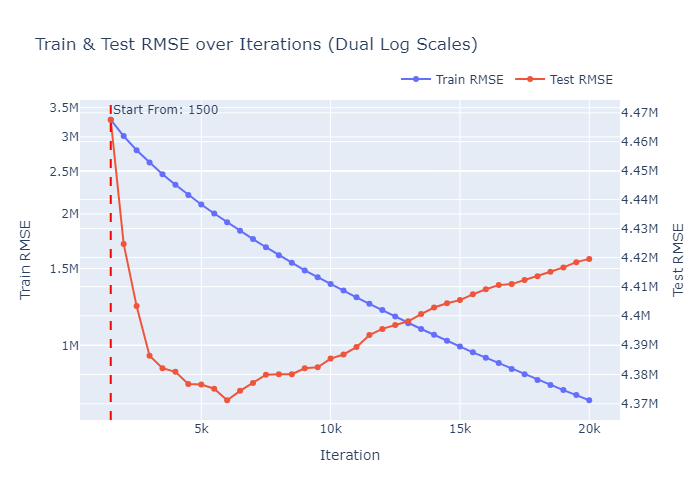

In [58]:
test_params_overfitting(hand_picked_params, "Hand-picked")

As expected, after around 6000 trees, there's a slight but steady upward trend in validation RMSE, while the training RMSE continues to steadily decrease - a classic case of overfitting.

In [40]:
results_overfitting_df

,Best iteration,Full model size (MB),Best iteration model size (MB),Final train RMSE,Final test RMSE,Best iteration RMSE,Difference (%)
Model,,,,,,,
Hand-picked,6134,52,16,749400,4419524,4370706,1.116918


## Larger model params

### Params

Let's change params significantly: increase `num_leaves` and `max_depth`, and decrease `min_child_samples`.

In [41]:
large_params = {
    "n_estimators": 20000,
    "learning_rate": 0.05,
    "num_leaves": 200,
    "max_depth": 40,
    "min_child_samples": 2,
    "verbose": -1,
    'random_state': 42,
}

### 🔍 ChatGPT parameter analysis:

| **Parameter**        | **Value**               | **Comment**                                                                 |
|----------------------|-------------------------|------------------------------------------------------------------------------|
| `learning_rate`      | 0.05                    | ✅ Moderate — balances speed and generalization, but needs monitoring.      |
| `num_leaves`         | 200                     | ⚠️ High — increases model complexity and risk of overfitting.               |
| `max_depth`          | 40                      | ❗ Extremely deep — allows very flexible trees, strong overfitting risk.     |
| `min_child_samples`  | 2                       | ❗ Very low — enables splits on small samples, promotes overfitting.         |


ChatGPT thinks these parameters are highly prone to overfitting.

### Expectation

Considering that these parameters are significantly more prone to overfitting, the test RMSE should start increasing more rapidly after a certain point compared to using hand-picked parameters. Also, the difference between the best score and the final score should be much larger.

### Reality

[500]	valid_0's rmse: 4.42059e+06	valid_0's l2: 1.95416e+13
[1000]	valid_0's rmse: 4.36745e+06	valid_0's l2: 1.90747e+13
[1500]	valid_0's rmse: 4.35027e+06	valid_0's l2: 1.89248e+13
[2000]	valid_0's rmse: 4.34681e+06	valid_0's l2: 1.88947e+13
[2500]	valid_0's rmse: 4.34332e+06	valid_0's l2: 1.88645e+13
[3000]	valid_0's rmse: 4.34306e+06	valid_0's l2: 1.88622e+13
[3500]	valid_0's rmse: 4.34267e+06	valid_0's l2: 1.88588e+13
[4000]	valid_0's rmse: 4.34328e+06	valid_0's l2: 1.8864e+13
[4500]	valid_0's rmse: 4.34352e+06	valid_0's l2: 1.88661e+13
[5000]	valid_0's rmse: 4.34349e+06	valid_0's l2: 1.88659e+13
[5500]	valid_0's rmse: 4.34366e+06	valid_0's l2: 1.88674e+13
[6000]	valid_0's rmse: 4.34378e+06	valid_0's l2: 1.88684e+13
[6500]	valid_0's rmse: 4.34391e+06	valid_0's l2: 1.88695e+13
[7000]	valid_0's rmse: 4.34401e+06	valid_0's l2: 1.88704e+13
[7500]	valid_0's rmse: 4.34413e+06	valid_0's l2: 1.88714e+13
[8000]	valid_0's rmse: 4.34416e+06	valid_0's l2: 1.88717e+13
[8500]	valid_0's rmse: 4.3

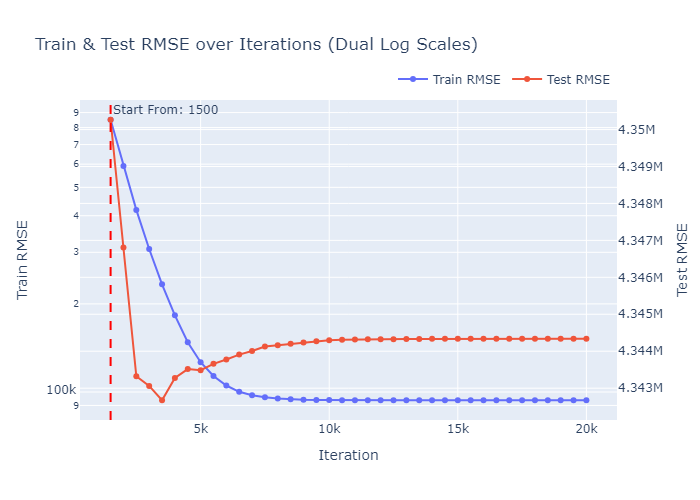

In [59]:

test_params_overfitting(large_params, "Large")

In [43]:
results_overfitting_df.sort_values(by='Final test RMSE')

,Best iteration,Full model size (MB),Best iteration model size (MB),Final train RMSE,Final test RMSE,Best iteration RMSE,Difference (%)
Model,,,,,,,
Large,3638,353,65,93751,4344339,4342453,0.043446
Hand-picked,6134,52,16,749400,4419524,4370706,1.116918


Huh? What’s happening here? A larger model, with parameters that supposedly were highly susceptible to overfitting, ends up with both a lower final RMSE and a smaller difference between it and the minimum RMSE. So it's actually overfitting less!

## Huge model params

### Params

Let’s go over the top: increase `num_leaves` to 1000 and set `max_depth` to -1 (unlimited).

In [44]:
huge_params = {
    "n_estimators": 20000,
    "learning_rate": 0.05,
    "num_leaves": 1000,
    "max_depth": -1,
    "min_child_samples": 2,
    "verbose": -1,
    'random_state': 42,
}

### 🔍 ChatGPT parameter analysis:

| **Parameter**        | **Value**               | **Comment**                                                                 |
|----------------------|-------------------------|------------------------------------------------------------------------------|
| `learning_rate`      | 0.05                    | ✅ Moderate — balances speed and generalization, but needs careful iteration control. |
| `num_leaves`         | 1000                    | ❗ Very high — model becomes highly expressive, easily overfits small patterns. |
| `max_depth`          | -1                      | ❗ Unlimited — trees can grow arbitrarily deep; must be capped or monitored.  |
| `min_child_samples`  | 2                       | ❗ Very low — allows splits on tiny subsets, increases variance and overfitting. |


### Expectation

Frankly, I expect it to kinda almost not work at all, and overfitting or degradation after some point in training should be just through the roof.

[500]	valid_0's rmse: 4.53078e+06	valid_0's l2: 2.0528e+13
[1000]	valid_0's rmse: 4.5295e+06	valid_0's l2: 2.05163e+13
[1500]	valid_0's rmse: 4.52965e+06	valid_0's l2: 2.05177e+13
[2000]	valid_0's rmse: 4.52971e+06	valid_0's l2: 2.05183e+13
[2500]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[3000]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[3500]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[4000]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[4500]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[5000]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[5500]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[6000]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[6500]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[7000]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[7500]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[8000]	valid_0's rmse: 4.52974e+06	valid_0's l2: 2.05185e+13
[8500]	valid_0's rmse: 4.52

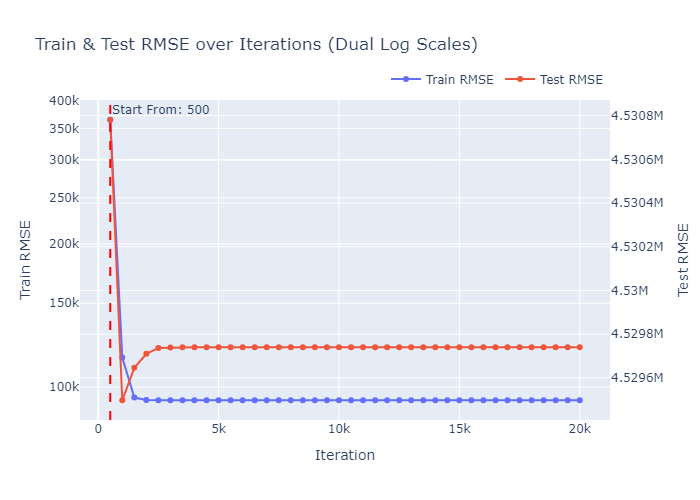

In [60]:
test_params_overfitting(huge_params, "Huge", plot_start_from=500, format='.6f')

In [46]:
results_overfitting_df.sort_values(by='Final test RMSE')

,Best iteration,Full model size (MB),Best iteration model size (MB),Final train RMSE,Final test RMSE,Best iteration RMSE,Difference (%)
Model,,,,,,,
Large,3638,353,65,93751,4344339,4342453,0.043446
Hand-picked,6134,52,16,749400,4419524,4370706,1.116918
Huge,1144,1900,102,93751,4529739,4529370,0.008157


In [25]:
hand_picked_rmse = results_overfitting_df.loc["Hand-picked", "Final test RMSE"]
huge_rmse = results_overfitting_df.loc["Huge", "Final test RMSE"]

difference = (huge_rmse - hand_picked_rmse) / hand_picked_rmse * 100
print(f"Difference between Hand-picked and Huge final RMSE: {difference:.3f}%")

Difference between Hand-picked and Huge final RMSE: 2.494%


What is going on? First of all, it performed better than I expected—only about 2.5% worse than the model with hand-picked parameters. But what's even more interesting is that the degradation of the test RMSE basically flattens out instead of rising rapidly.

## Intermediate conclusions

So it seems like reality hits again: at least when using LGBM, there is no textbook degradation of the validation score as training progresses. In fact, it's quite the opposite. The largest model is clearly overfitting - it achieves the lowest training RMSE of all, but its validation score simply flattens out. On the other hand, the smallest and least capable model shows textbook signs of overfitting, even though it's actually underfitting. It's too small to learn real patterns in the data, so its validation error starts rising after a certain point.

## Real (?) overfitting

So, let's try to see real overfitting. Basically, the expectation is like this: smaller models underfit – show higher RMSE score on the test set; as model size increases, it starts to learn better, but after some time comes overfitting. The model is too large for its own good and starts to generalize poorly, which we would see as an increase of RMSE score. If we plot, then, model complexity vs. RMSE, we should see a U-shape, with optimal models at the bottom, and underfitting/overfitting ones to the sides.

### Grid Search

In [61]:
X_grid_search = df.drop(columns=['price'])
y_grid_search = df['price']

In [62]:
param_grid = {
    'num_leaves': [10, 20, 25, 31, 50, 100, 150, 200, 250, 300, 500, 1000],
    'max_depth': [5, 8, 9, 10, 15, 20, 25, 30, 35, 40, 50, 100, 200],
    'min_child_samples': [2, 3, 5, 10, 15, 20, 25, 30, 40, 50],
}
# param_grid = {
#     'num_leaves': [1000, 500, 300, 250, 200, 150, 100, 50, 31, 25, 20, 10],
#     'max_depth': [200, 100, 50, 40, 35, 30, 25, 20, 15, 10, 9, 8, 5],
#     'min_child_samples': [50, 40, 30, 25, 20, 15, 10, 5, 3, 2],
# }

In [ ]:
# csv_path = '../data/real_overfitting.csv'
# real_overfitting_df = pd.read_csv(csv_path)

In [ ]:
grid = list(ParameterGrid(param_grid))
csv_path = '../data/real_overfitting.csv'
os.makedirs('../data', exist_ok=True)

# Load or init results
if os.path.exists(csv_path):
    real_overfitting_df = pd.read_csv(csv_path)
else:
    real_overfitting_df = pd.DataFrame({
        'num_leaves': pd.Series(dtype='int'),
        'max_depth': pd.Series(dtype='int'),
        'min_child_samples': pd.Series(dtype='float'),
        'best iteration': pd.Series(dtype='int'),
        'model size': pd.Series(dtype='int'),
        'train rmse': pd.Series(dtype='int'),
        'test rmse': pd.Series(dtype='int'),
        'test rmse stddev': pd.Series(dtype='float'),
    })

# Already evaluated params for skipping
already_seen = set(
    tuple(row) for row in real_overfitting_df[['num_leaves', 'max_depth', 'min_child_samples']].to_numpy()
)

# Grid Search
for params in tqdm(grid, desc="Running Grid Search"):
    key = (params['num_leaves'], params['max_depth'], params['min_child_samples'])
    if key in already_seen:
        continue

    train_rmses = []
    test_rmses = []
    best_iterations = []
    model_sizes = []

    FOLDS = 10
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

    for i, (train_index, test_index) in enumerate(kf.split(X_grid_search, y_grid_search)):
        X_train_cv_fold = X_grid_search.iloc[train_index].copy()
        y_train_cv_fold = y_grid_search.iloc[train_index].copy()
        X_valid_fold = X_grid_search.iloc[test_index].copy()
        y_valid_fold = y_grid_search.iloc[test_index].copy()

        encode_map_city(X_train_cv_fold, y_train_cv_fold, X_valid_fold)

        model = LGBMRegressor(**{
            'n_estimators': 10000,
            'learning_rate': 0.05,
            'num_leaves': params['num_leaves'],
            'max_depth': params['max_depth'],
            'min_child_samples': params['min_child_samples'],
            'verbose': -1,
            'random_state': 42,
            'n_jobs': -1,
        })
        model.fit(
            X_train_cv_fold, y_train_cv_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            eval_metric='rmse',
            callbacks=[
                lgb.early_stopping(250, verbose=False),
            ],
        )

        train_rmse = root_mean_squared_error(y_train_cv_fold, model.predict(X_train_cv_fold))
        eval_results = model.evals_result_
        valid_rmse_history = eval_results['valid_0']['rmse']
        valid_rmse = valid_rmse_history[model.best_iteration_ - 1]

        train_rmses.append(train_rmse)
        test_rmses.append(valid_rmse)
        best_iterations.append(model.best_iteration_)

        model_path = f"../data/models/lgbm_grid_search.txt"
        model.booster_.save_model(model_path)
        model_size = os.path.getsize(model_path)
        model_sizes.append(model_size)


    real_overfitting_df.loc[len(real_overfitting_df)] = {
        'num_leaves': params['num_leaves'],
        'max_depth': params['max_depth'],
        'min_child_samples': params['min_child_samples'],
        'best iteration': int(np.mean(best_iterations)),
        'model size': int(np.mean(model_sizes)),
        'train rmse': int(np.mean(train_rmses)),
        'test rmse': int(np.mean(test_rmses)),
        'test rmse stddev': float(np.std(test_rmses, ddof=1)),
    }

    print(f"Num leaves: {params['num_leaves']}, Max depth: {params['max_depth']}, Min child samples: {params['min_child_samples']}")


    # Update seen set and save
    already_seen.add(key)
    real_overfitting_df.to_csv(csv_path, index=False)

Running Grid Search: 100%|██████████| 1560/1560 [00:00<00:00, 173341.31it/s]


### Params in 3D

#### All params

In [ ]:
fig = px.scatter_3d(
    real_overfitting_df,
    x='num_leaves',
    y='max_depth',
    z='min_child_samples',
    color='test rmse',
    color_continuous_scale='Viridis',
    title='RMSE across Grid Search Params (3D)',
    height=800,
)
fig.update_traces(marker=dict(size=4))
show_fig(fig)

#### Params with RMSE < 4330000

In [ ]:
filtered_df = real_overfitting_df[real_overfitting_df['test rmse'] < 4330000]

fig = px.scatter_3d(
    filtered_df,
    x='num_leaves',
    y='max_depth',
    z='min_child_samples',
    color='test rmse',
    color_continuous_scale='Viridis',
    title='RMSE across Grid Search Params (3D)',
    height=800,
)
fig.update_traces(marker=dict(size=4))
show_fig(fig)

#### Params with RMSE > 4500000

In [ ]:
filtered_df = real_overfitting_df[real_overfitting_df['test rmse'] > 4500000]

fig = px.scatter_3d(
    filtered_df,
    x='num_leaves',
    y='max_depth',
    z='min_child_samples',
    color='test rmse',
    color_continuous_scale='Viridis',
    title='RMSE across Grid Search Params (3D)',
    height=800,
)
fig.update_traces(marker=dict(size=4))
show_fig(fig)

In [34]:
real_overfitting_df.sort_values(by='test rmse').head(20)

,num_leaves,max_depth,min_child_samples,best iteration,model size,train rmse,test rmse,test rmse stddev
1074,100,15,2,4708,43928428,639456,4340532,131094.596010
953,150,20,2,3708,52061646,519308,4341559,128994.516580
834,100,25,2,4597,42918090,641821,4342491,123097.153489
954,100,20,2,4735,44217377,630894,4343096,123576.364663
929,150,20,5,2552,36085516,817624,4345642,136420.663990
833,150,25,2,3314,46523747,557946,4345771,131364.579244
1063,50,15,3,5686,26701298,1139862,4345839,127679.060962
955,50,20,2,6918,32728929,922592,4347498,116302.505721
943,50,20,3,6419,30147889,1011563,4347702,128241.860572
930,100,20,5,3795,35689053,895014,4347991,138615.979706


### Params distribution

In [64]:
def plot_param_distribution(df, title):
    # create a 1×3 subplot figure
    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=[
            "num_leaves",
            "max_depth",
            "min_child_samples"
        ]
    )

    # loop through each parameter and its bins
    for i, (param, bins) in enumerate(param_grid.items(), start=1):
        # add the histogram for this param into the i-th column
        fig.add_trace(
            go.Histogram(
                x=df[param],
                nbinsx=len(bins),      # one bin per category
                showlegend=False
            ),
            row=1, col=i
        )
        # force categorical ordering on the x-axis
        fig.update_xaxes(
            row=1, col=i,
            type='category',
            categoryorder='array',
            categoryarray=bins
        )

    # tweak overall layout
    fig.update_layout(
        title_text=f"Distributions of Parameters in {title}",
        bargap=0.1,
        # width=1000,
        # height=400,
    )

    show_fig(fig)

#### 100 best params

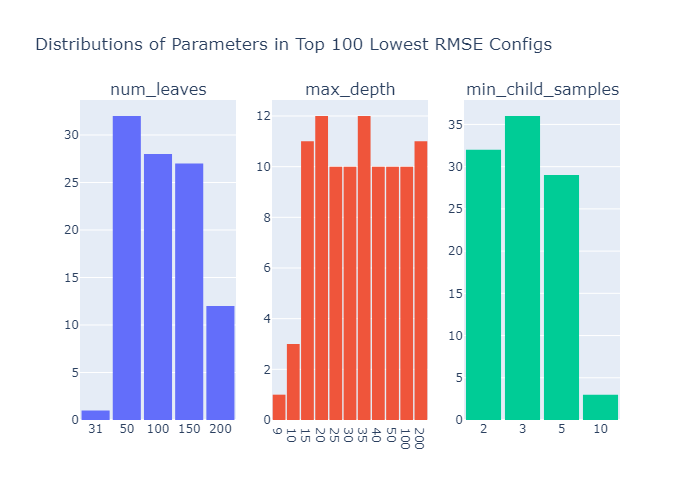

In [65]:
top_100 = real_overfitting_df.nsmallest(100, 'test rmse')
plot_param_distribution(top_100, 'Top 100 Lowest RMSE Configs')

#### 100 worst params

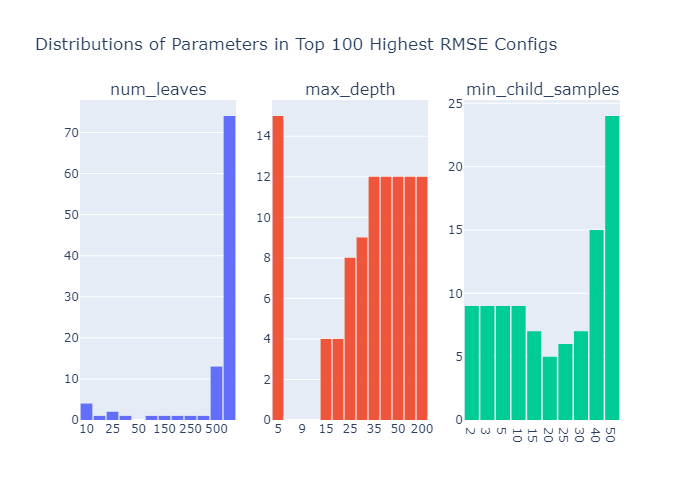

In [66]:
bottom_100 = real_overfitting_df.nlargest(100, 'test rmse')

plot_param_distribution(bottom_100, 'Top 100 Highest RMSE Configs')

#### 100 worst params with `num_leaves` < 500

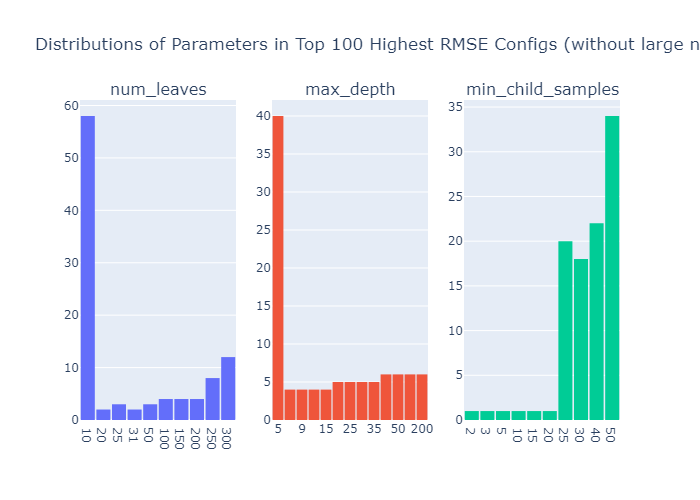

In [67]:
bottom_100_wo_large_n_leaves = real_overfitting_df[real_overfitting_df['num_leaves'] < 500]
bottom_100_wo_large_n_leaves = bottom_100_wo_large_n_leaves.nlargest(100, 'test rmse')
plot_param_distribution(bottom_100_wo_large_n_leaves, 'Top 100 Highest RMSE Configs (without large num_leaves)')

#### RMSE

In [68]:
def plot_rmse(df, param_name):
    avg_df = df.groupby(param_name, as_index=False).agg({
        "model size": "mean",
        "test rmse": "mean"
    })

    fig_rmse = px.line(avg_df, x=param_name, y="test rmse", markers=True,
                    title=f"Average Test RMSE vs {param_name}")
    fig_rmse.update_layout(xaxis_title=param_name, yaxis_title="Average Test RMSE")
    fig_rmse.show()

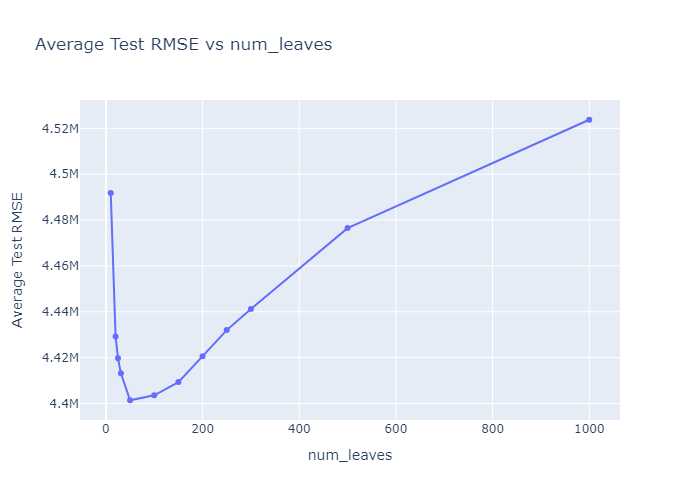

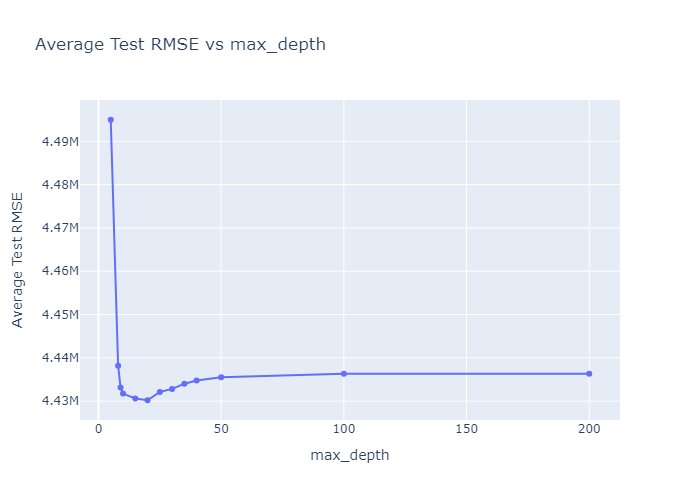

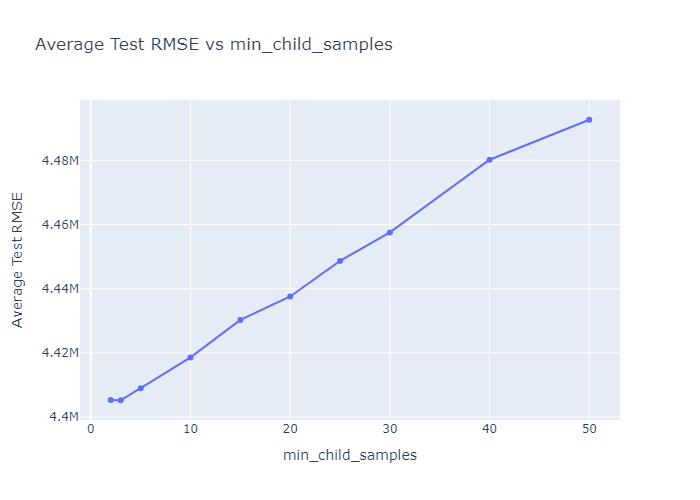

In [69]:
plot_rmse(real_overfitting_df, "num_leaves")
plot_rmse(real_overfitting_df, "max_depth")
plot_rmse(real_overfitting_df, "min_child_samples")

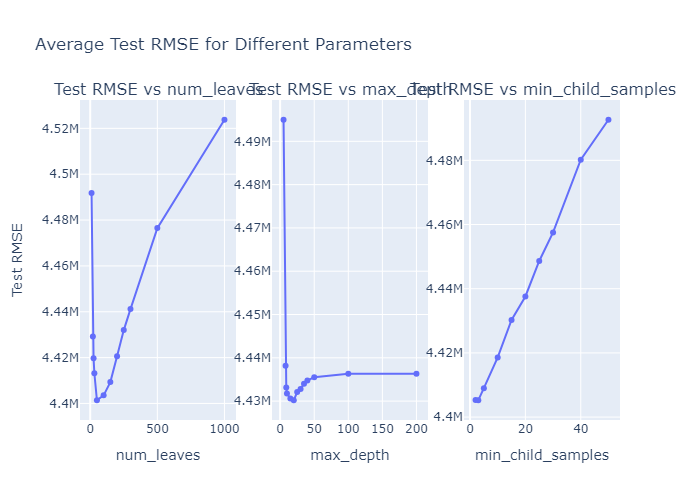

In [70]:
def plot_rmse_side_by_side(df, param_names):
    fig = make_subplots(rows=1, cols=len(param_names), subplot_titles=[
        f"Test RMSE vs {param}" for param in param_names
    ])

    for i, param in enumerate(param_names, start=1):
        avg_df = df.groupby(param, as_index=False).agg({
            "test rmse": "mean"
        })

        fig_part = px.line(avg_df, x=param, y="test rmse", markers=True)
        for trace in fig_part.data:
            fig.add_trace(trace, row=1, col=i)

        fig.update_xaxes(title_text=param, row=1, col=i)

    fig.update_layout(height=400, width=1000, showlegend=False,
                      title_text="Average Test RMSE for Different Parameters",
                      yaxis_title="Test RMSE")
    show_fig(fig)

plot_rmse_side_by_side(real_overfitting_df, ["num_leaves", "max_depth", "min_child_samples"])

#### Params analysis

- `num_leaves`: < 20 - underfitting, > 150 - overfitting
- `max_depth`: < 10 - underfitting, everything else is viable, probalby large max_depth just doesn't get used all the way
- `min_child_samples`: 2-5 good range, everything over it is overfitting, which is surprising

### Model capacity

To plot model capacity, we need to calculate some metric that would be a proxy for model capacity. To do so, we would simply sum indexes of params (with min_child_samples reversed).

In [71]:
idx_leaves = {v: i for i, v in enumerate(param_grid['num_leaves'])}
idx_depth = {v: i for i, v in enumerate(param_grid['max_depth'])}
idx_child = {v: i for i, v in enumerate(param_grid['min_child_samples'])}
max_child_idx = len(param_grid['min_child_samples']) - 1

real_overfitting_df['i_leaves'] = real_overfitting_df['num_leaves'].map(idx_leaves)
real_overfitting_df['i_depth'] = real_overfitting_df['max_depth'].map(idx_depth)
real_overfitting_df['i_child'] = real_overfitting_df['min_child_samples'].map(lambda x: max_child_idx - idx_child[x])

real_overfitting_df['capacity'] = real_overfitting_df['i_leaves'] + real_overfitting_df['i_depth'] + real_overfitting_df['i_child']
# real_overfitting_df['complexity_add'] = real_overfitting_df['i_leaves'] + real_overfitting_df['i_child']

real_overfitting_df.drop(columns=['i_leaves', 'i_depth', 'i_child'], inplace=True)

In [72]:
real_overfitting_df.nsmallest(10, 'test rmse')

,num_leaves,max_depth,min_child_samples,best iteration,model size,train rmse,test rmse,test rmse stddev,capacity
1074,100,15,2,4708,43928428,639456,4340532,131094.596010,18
953,150,20,2,3708,52061646,519308,4341559,128994.516580,20
834,100,25,2,4597,42918090,641821,4342491,123097.153489,20
954,100,20,2,4735,44217377,630894,4343096,123576.364663,19
929,150,20,5,2552,36085516,817624,4345642,136420.663990,18
833,150,25,2,3314,46523747,557946,4345771,131364.579244,21
1063,50,15,3,5686,26701298,1139862,4345839,127679.060962,16
955,50,20,2,6918,32728929,922592,4347498,116302.505721,18
943,50,20,3,6419,30147889,1011563,4347702,128241.860572,17
930,100,20,5,3795,35689053,895014,4347991,138615.979706,17


In [73]:
real_overfitting_df.nlargest(10, 'test rmse')

,num_leaves,max_depth,min_child_samples,best iteration,model size,train rmse,test rmse,test rmse stddev,capacity
120,1000,100,50,499,28617214,1852458,4606327,151741.034132,22
0,1000,200,50,482,27637898,1884280,4602577,153382.949895,23
12,1000,200,40,457,32670452,1608440,4595139,155456.955344,24
1,500,200,50,600,25928049,1794538,4592886,152922.311411,22
121,500,100,50,606,26182900,1783718,4591961,152467.073355,21
132,1000,100,40,439,31301027,1664559,4591896,156014.105355,23
240,1000,50,50,604,25570407,1859536,4587290,161869.026511,21
241,500,50,50,532,20530276,2017431,4585421,160037.346680,20
144,1000,100,30,370,31694141,1426294,4585368,159168.640207,24
24,1000,200,30,412,35241796,1333247,4584339,158479.593765,25


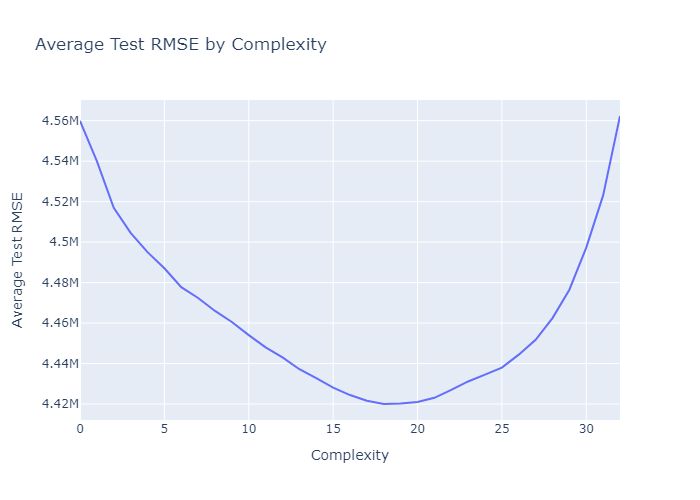

In [74]:
avg_rmse_df = real_overfitting_df.groupby("capacity", as_index=False)["test rmse"].mean()

# Sort by complexity for a smoother line
avg_rmse_df = avg_rmse_df.sort_values("capacity")

# Plot line chart
fig = px.line(avg_rmse_df, x="capacity", y="test rmse", markers=False,
              title="Average Test RMSE by Complexity")
fig.update_layout(xaxis_title="Complexity", yaxis_title="Average Test RMSE")
show_fig(fig)

Finally! There it is. Exactly as expected.

### Model Size

In [45]:
real_overfitting_df['model size'].min(), real_overfitting_df['model size'].max()

(8683024, 114958644)

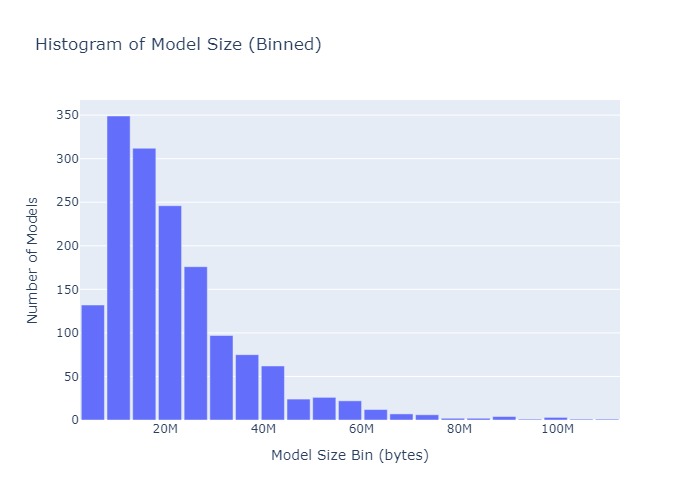

In [75]:
# Bin size
bin_size = 5 * 1024 * 1024  # 5 MB

# Create model size bins
real_overfitting_df["model_size_bin"] = (
    (real_overfitting_df["model size"] // bin_size) * bin_size
)

# Count number of models in each bin
binned_counts = real_overfitting_df.groupby("model_size_bin").size().reset_index(name="count")

# Plot histogram using pre-binned data
fig = px.bar(binned_counts, x="model_size_bin", y="count",
             title="Histogram of Model Size (Binned)",
             labels={"model_size_bin": "Model Size Bin (bytes)", "count": "Number of Models"})

fig.update_layout(bargap=0.1)
show_fig(fig)

#### Model size by capacity

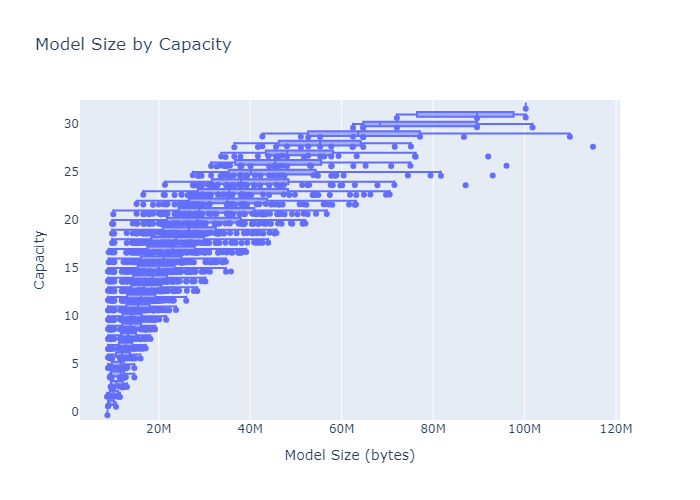

In [76]:
fig = px.box(real_overfitting_df, x="model size", y="capacity", orientation='h', points="all", title="Model Size by Capacity")
fig.update_layout(yaxis_title="Capacity", xaxis_title="Model Size (bytes)")
show_fig(fig)

#### Average RMSE by model size

In [77]:
BIN_MIB = 5
THRESHOLD_MIB = 65

def custom_model_size_bin(size_bytes):
    size_mib = size_bytes / (1024 * 1024)
    if size_mib < THRESHOLD_MIB:
        return (int(size_mib) // BIN_MIB) * BIN_MIB
    else:
        return THRESHOLD_MIB

real_overfitting_df["model_size_bin"] = real_overfitting_df["model size"].apply(custom_model_size_bin)
real_overfitting_df["model_size_bin_label"] = real_overfitting_df["model_size_bin"].apply(
    lambda x: "65MB+" if x == THRESHOLD_MIB else f"{x}MB"
)

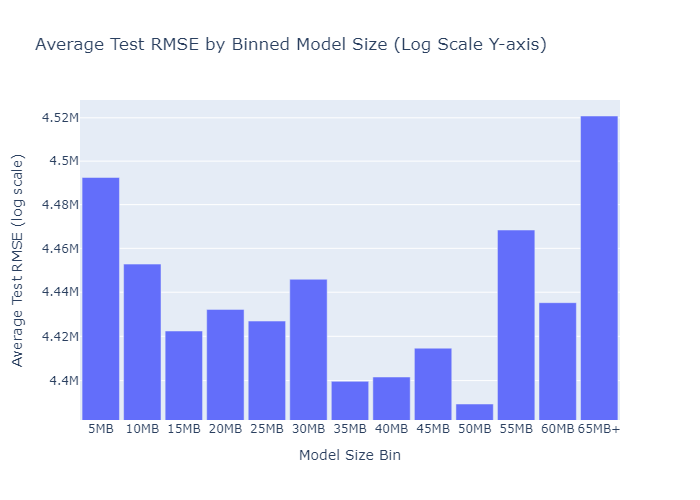

In [78]:
# Group by bin and compute average test RMSE
rmse_avg_df = real_overfitting_df.groupby(["model_size_bin_label"], as_index=False)["test rmse"].mean()

# Create correct sorted label order
bin_labels_ordered = [
    f"{i}MB" for i in range(0, THRESHOLD_MIB, BIN_MIB)
] + ["65MB+"]

fig2 = px.bar(
    rmse_avg_df,
    x="model_size_bin_label",
    y="test rmse",
    title="Average Test RMSE by Binned Model Size (Log Scale Y-axis)",
    category_orders={"model_size_bin_label": bin_labels_ordered}
)
fig2.update_layout(
    xaxis_title="Model Size Bin",
    yaxis_title="Average Test RMSE (log scale)",
    bargap=0.1,
    yaxis_type="log"
)
fig2.show()


Not as pretty as the capacity plot - probably because higher capacity doesn't necessarily mean a larger model size, since we use early stopping.

#### Average best iteration by model size

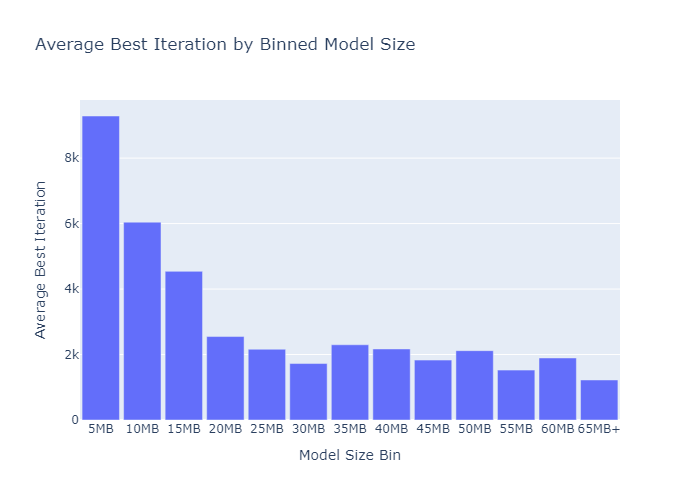

In [79]:
# Group by bin and compute average best iteration
best_iter_avg_df = real_overfitting_df.groupby(["model_size_bin_label"], as_index=False)["best iteration"].mean()

# Create correct sorted label order
bin_labels_ordered = [
    f"{i}MB" for i in range(0, THRESHOLD_MIB, BIN_MIB)
] + ["65MB+"]

# Create bar plot
fig2 = px.bar(
    best_iter_avg_df,
    x="model_size_bin_label",
    y="best iteration",
    title="Average Best Iteration by Binned Model Size",
    category_orders={"model_size_bin_label": bin_labels_ordered}
)
fig2.update_layout(
    xaxis_title="Model Size Bin",
    yaxis_title="Average Best Iteration",
    bargap=0.1
)
fig2.show()


#### Relative compositon of capacity by model size

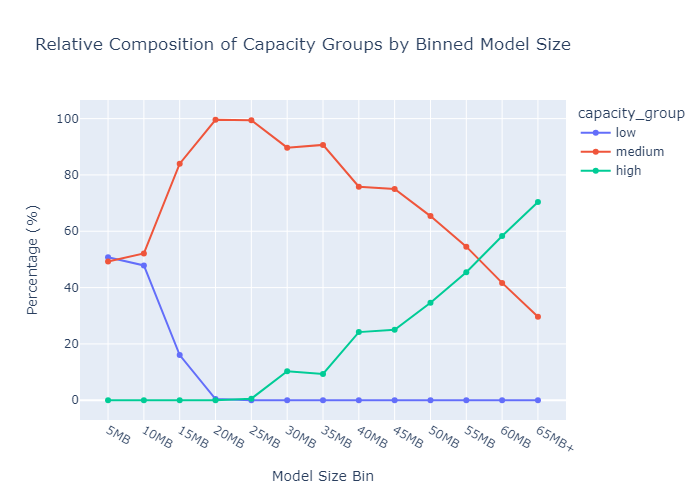

In [80]:
# Step 1: Categorize complexity
def categorize_complexity(x):
    if x <= 10:
        return "low"
    elif x <= 25:
        return "medium"
    else:
        return "high"

real_overfitting_df["capacity_group"] = real_overfitting_df["capacity"].apply(categorize_complexity)

# ✅ Grouping with labels preserved
total_counts = real_overfitting_df.groupby(["model_size_bin_label"]).size().reset_index(name="total")
group_counts = real_overfitting_df.groupby(["model_size_bin_label", "capacity_group"]).size().reset_index(name="count")

# ✅ Merge on both model_size_bin and label to keep it clean
merged = pd.merge(group_counts, total_counts, on=["model_size_bin_label"])
merged["percentage"] = (merged["count"] / merged["total"]) * 100

# ✅ Pivot and melt
pivot_df = merged.pivot(index=["model_size_bin_label"], columns="capacity_group", values="percentage").fillna(0).reset_index()
melted = pivot_df.melt(id_vars=["model_size_bin_label"], var_name="capacity_group", value_name="percentage")



# Define bin label order
bin_labels_ordered = [f"{i}MB" for i in range(5, THRESHOLD_MIB, BIN_MIB)] + ["65MB+"]

# All capacity groups (hardcoded or dynamic)
capacity_groups = ["low", "medium", "high"]

# Create a full cartesian product of all bin × group combinations
full_index = pd.DataFrame(list(product(bin_labels_ordered, capacity_groups)),
                          columns=["model_size_bin_label", "capacity_group"])

# Merge with actual data and fill missing percentages with 0
melted_full = pd.merge(full_index, melted, on=["model_size_bin_label", "capacity_group"], how="left")
melted_full["percentage"] = melted_full["percentage"].fillna(0)

# Convert label column to ordered categorical
melted_full["model_size_bin_label"] = pd.Categorical(
    melted_full["model_size_bin_label"],
    categories=bin_labels_ordered,
    ordered=True
)

# Plot again
fig = px.line(
    melted_full,
    x="model_size_bin_label",
    y="percentage",
    color="capacity_group",
    markers=True,
    title="Relative Composition of Capacity Groups by Binned Model Size"
)
fig.update_layout(
    xaxis_title="Model Size Bin",
    yaxis_title="Percentage (%)"
)
show_fig(fig)

#### Model size params plot

In [82]:
def plot_model_size(df, param_name):
    # Create a new DataFrame with average values
    avg_df = df.groupby(param_name, as_index=False).agg({
        "model size": "mean",
        "test rmse": "mean"
    })

    fig_model_size = px.line(avg_df, x=param_name, y="model size", markers=True,
                             title=f"Average Model Size vs {param_name}")
    fig_model_size.update_layout(xaxis_title=param_name, yaxis_title="Average Model Size (bytes)")
    fig_model_size.show()

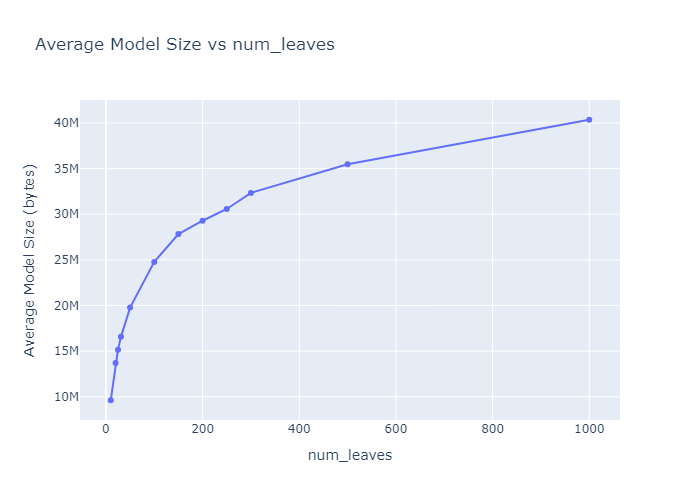

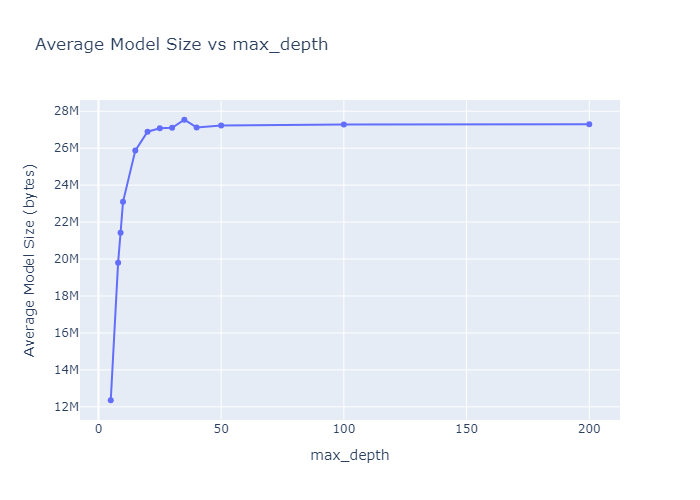

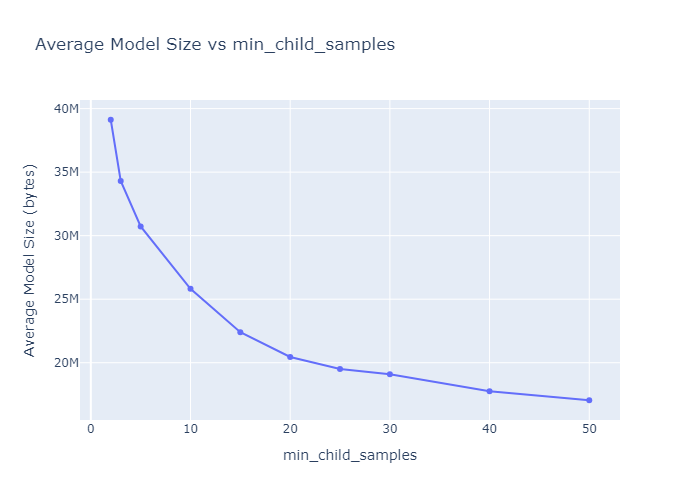

In [83]:
plot_model_size(real_overfitting_df, "num_leaves")
plot_model_size(real_overfitting_df, "max_depth")
plot_model_size(real_overfitting_df, "min_child_samples")

### RMSE vs RMSE Standard deviation

In [54]:
real_overfitting_df['rank_rmse'] = real_overfitting_df['test rmse'].rank(method='min')
real_overfitting_df['rank_std'] = real_overfitting_df['test rmse stddev'].rank(method='min')
real_overfitting_df['rank_diff'] = (real_overfitting_df['rank_rmse'] - real_overfitting_df['rank_std']).abs()

In [55]:
real_overfitting_df[['num_leaves', 'max_depth', 'min_child_samples', 'test rmse', 'test rmse stddev', 'rank_rmse', 'rank_std', 'rank_diff']].sort_values(by='test rmse').head(10)

,num_leaves,max_depth,min_child_samples,test rmse,test rmse stddev,rank_rmse,rank_std,rank_diff
1074,100,15,2,4340532,131094.596010,1.0,368.0,367.0
953,150,20,2,4341559,128994.516580,2.0,272.0,270.0
834,100,25,2,4342491,123097.153489,3.0,78.0,75.0
954,100,20,2,4343096,123576.364663,4.0,90.0,86.0
929,150,20,5,4345642,136420.663990,5.0,753.0,748.0
833,150,25,2,4345771,131364.579244,6.0,395.0,389.0
1063,50,15,3,4345839,127679.060962,7.0,218.0,211.0
955,50,20,2,4347498,116302.505721,8.0,7.0,1.0
943,50,20,3,4347702,128241.860572,9.0,237.0,228.0
930,100,20,5,4347991,138615.979706,10.0,899.0,889.0


In [56]:
real_overfitting_df[['num_leaves', 'max_depth', 'min_child_samples', 'test rmse', 'test rmse stddev', 'rank_rmse', 'rank_std', 'rank_diff']].sort_values(by='rank_std').head(10)

,num_leaves,max_depth,min_child_samples,test rmse,test rmse stddev,rank_rmse,rank_std,rank_diff
1425,25,8,3,4387014,112016.841799,324.0,1.0,323.0
1409,150,8,5,4406612,113428.409365,507.0,2.0,505.0
1428,1000,8,2,4421579,115183.180143,653.0,3.0,650.0
1429,500,8,2,4421579,115183.180143,653.0,3.0,650.0
1430,300,8,2,4421579,115183.180143,653.0,3.0,650.0
1263,250,9,15,4426857,116184.980454,707.0,6.0,701.0
955,50,20,2,4347498,116302.505721,8.0,7.0,1.0
1304,31,9,3,4388471,116362.501325,342.0,8.0,334.0
1434,100,8,2,4387579,116663.932209,328.0,9.0,319.0
811,50,25,5,4350629,116742.870191,25.0,10.0,15.0


In [57]:
real_overfitting_df['rank_diff'].describe()

count    1560.000000
mean      344.947436
std       287.230278
min         0.000000
25%       106.750000
50%       270.000000
75%       512.000000
max      1428.000000
Name: rank_diff, dtype: float64

The average gap between the mean RMSE and the RMSE standard deviation is quite large, which is interesting. So, it probably makes sense to consider both metrics when choosing a model. In this case, it probably makes sense to select model #955, which ranks 8th by mean RMSE and 7th by RMSE standard deviation.

In [58]:
real_overfitting_df.iloc[955]

num_leaves                         50
max_depth                          20
min_child_samples                   2
best iteration                   6918
model size                   32728929
train rmse                     922592
test rmse                     4347498
test rmse stddev        116302.505721
capacity                           18
model_size_bin                     30
model_size_bin_label             30MB
capacity_group                 medium
rank_rmse                         8.0
rank_std                          7.0
rank_diff                         1.0
Name: 955, dtype: object

## Conclusions

- LGBM is hard to break — the algorithm is inherently self-regulating.
- Big capacity ≠ big model. A model with high capacity tends to hit its limit and plateau faster.
- Underfitting can *look* like textbook overfitting.
- LGBM **can** overfit.
- The range of parameter values that work well in practice is much broader than conventional wisdom suggests.
- Definitely use early stopping — but *test* it. The typical range of 50–100 rounds might not be right for your setup.
